In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 40  # Tamaño del dominio (en unidades adimensionales)
N = 3000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.0005  # Paso temporal (en unidades adimensionales)
t_max = 4 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = -4 # Posición inicial partícula
kappa_0 = 8 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)



# Barrera de potencial
alpha_param = 6  
v_0 = 0 # Altura del potencial (V_0/Ec)
b = 1 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial


In [54]:
def solve_crank_nicolson (kappa_0, dx, dt, v, psi0, t):

    t_steps = int(t / dt) 
        
    # Matrices Crank-Nicolson 
    alpha = 1j * dt / (kappa_0 * dx**2)  
    beta = 1j * dt * kappa_0 / 2  

    diagonal_a = (1 + alpha + beta * v) * np.ones(N)
    off_diagonal = -(alpha / 2) * np.ones(N - 1)
    A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

    diagonal_b = (1 - alpha - beta * v) * np.ones(N)
    B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")
    
    # Inicialización de la función de onda
    psi = psi0.copy()

    # Solución del problema
    for t in range(t_steps):
        psi = spsolve(A, B @ psi)

    return psi

In [55]:
def tunneling_probability (b,psi):

    # Calcular el índice correspondiente a x = b en la malla xi
    b_index = np.where(xi >= b)[0][0]  # Primer índice donde xi >= b

    # Densidad de probabilidad |psi(x,t)|^2 en la región x >= b
    prob_density_right = np.abs(psi[b_index:])**2

    # Interpolación de la densidad de probabilidad en la región x >= b
    interp_prob_density = interp1d(xi[b_index:], prob_density_right, kind='cubic', fill_value="extrapolate")

    # Integración de la densidad de probabilidad desde x = b hasta infinito (ultimo punto de la malla xi)
    prob_tunel, error = quad(interp_prob_density, b, xi[-1])

    return prob_tunel

In [56]:
def perform_position_measurement (psi, xi, measurement_width):
    
    # Calculate the center of the wave packet as the weighted average position
    center = np.sum(xi * np.abs(psi)**2) / np.sum(np.abs(psi)**2) 

    # Define the measurement range around the center
    x_min = center - measurement_width / 2
    x_max = center + measurement_width / 2

    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Create a new wavefunction that is zero outside the measurement range
    psi_measured = np.zeros_like(psi)
    psi_measured[measurement_indices] = psi[measurement_indices]


    return psi_measured


In [57]:
def gaussian_projection (psi, xi):
    dx = xi[1] - xi[0]  # Paso espacial, asumiendo una malla uniforme

    # Calculate the center of the wave packet as the weighted average position
    center = np.sum(xi * np.abs(psi)**2) / np.sum(np.abs(psi)**2) 
    
    # Función gaussiana centrada en el centro del paquete actual, pero con ancho sigma0
    psi_gaussian = (2 / np.pi)**(1/4) * np.exp(-(xi - center)**2) * np.exp(1j * kappa_0 * xi)
    
    # Producto interno entre psi_gaussiana y psi_actual
    dot_prod = np.sum(np.conjugate(psi_gaussian) * psi) * dx
    
    proyeccion = dot_prod 
    
    # Proyección: escalar psi_gaussiana por el coeficiente de proyección
    psi_proyectada = proyeccion * psi
    
    return psi_proyectada  # Retorna la función proyectada y la probabilidad

In [58]:
def calculate_position_probability(psi, xi, measurement_width):
    
    # Calculate the center of the wave packet 
    probability_density = np.abs(psi)**2
    max_index = np.argmax(probability_density)
    center = xi[max_index]

    # Define the measurement range around the center
    x_min = center - measurement_width / 2
    x_max = center + measurement_width / 2

    # Identify the indices of the spatial grid that fall within the measurement range
    measurement_indices = (xi >= x_min) & (xi <= x_max)

    # Calculate the probability by integrating the probability density over the measurement range
    probability = trapezoid(np.abs(psi[measurement_indices])**2, xi[measurement_indices])

    return probability

In [59]:
def perform_Zeno (N_measurements, psi, measurement_width): # Under position Measurements

    if N_measurements == 0:

        print ('No Zeno Effect')

        psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi, t_max)

        prod = calculate_position_probability(psi, xi, measurement_width)

        print('Tunneling probability = ', prod, ' ( No Zeno )')
        
    else:
        time_step = t_max / N_measurements

        probs = []
    
        for measurement in range (N_measurements):
            
            psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi, time_step)

            p = 1

            probs.append(p)

            psi = gaussian_projection (psi, xi)
        
        prod = 1

        for prob in probs: 
            prod = prod * prob 
        
        print('Tunneling probability = ', prod, ' ( Zeno, N =', N_measurements,')') 

        psi = np.sqrt(prod) * psi # Normalización pendiente de revisar

    
    
    return psi 

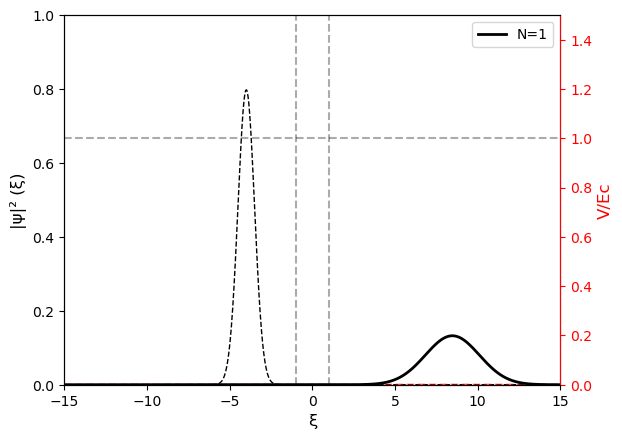

In [63]:
# Plot
fig, ax = plt.subplots()

# Plot de la densidad de probabilidad
ax.set_xlim(-15, 15)
ax.set_ylim(0, 1)  
ax.set_ylabel('|ψ|² (ξ)', size=12)

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel('V/Ec',color='r',size = 12)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax.set_xlabel('ξ', fontsize=12)

ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)
plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

line, = ax.plot(xi, np.abs(psi0)**2,color='k', linestyle ='--',linewidth=1) # input wavepacket

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='--',alpha = 0.65 )


measurement_width = 3.0



########################################################################################################################
N_measurements = 1

t_max = 6.24

psi = psi0.copy()  # Initial wavefunction

psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi, t_max)

psi = gaussian_projection (psi, xi)

line, = ax.plot(xi, np.abs(psi)**2, label=f'N={N_measurements}',color='k',linewidth=2) # plot de |psi|^2

########################################################################################################################



ax.legend(loc='upper right', fontsize=10)

plt.show()

/tmp/ipykernel_19249/1083396584.py:5: RuntimeWarning: invalid value encountered in scalar divide
  center = np.sum(xi * np.abs(psi)**2) / np.sum(np.abs(psi)**2)


KeyboardInterrupt: 

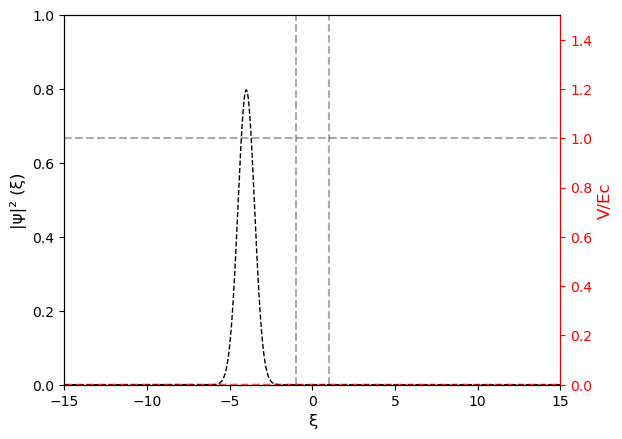

In [61]:
# Plot
fig, ax = plt.subplots()

# Plot de la densidad de probabilidad
ax.set_xlim(-15, 15)
ax.set_ylim(0, 1)  
ax.set_ylabel('|ψ|² (ξ)', size=12)

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel('V/Ec',color='r',size = 12)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax.set_xlabel('ξ', fontsize=12)

ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)
plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

line, = ax.plot(xi, np.abs(psi0)**2,color='k', linestyle ='--',linewidth=1) # input wavepacket

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='--',alpha = 0.65 )


measurement_width = 3.0



########################################################################################################################
N_measurements = 500

t_max = 6.24

psi = psi0.copy()  # Initial wavefunction

psi = perform_Zeno (N_measurements, psi, measurement_width)

line, = ax.plot(xi, np.abs(psi)**2, label=f'N={N_measurements}',color='k',linewidth=2) # plot de |psi|^2

########################################################################################################################



ax.legend(loc='upper right', fontsize=10)

plt.show()